In [ ]:
import glob
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
import torchvision.transforms as tfms
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn.functional as F
import scipy as sc
import os
import PIL
import PIL.Image as Image
import seaborn as sns
import warnings
import nibabel as nib

In [ ]:
# mount to google drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:

data_path="/content/drive/My Drive/Colab Notebooks/adult_mri_dataset_shahad/"


<class 'numpy.ndarray'>
(256, 128, 256, 1)
(256, 256, 128)


Text(0.5, 1.0, 'Mask')

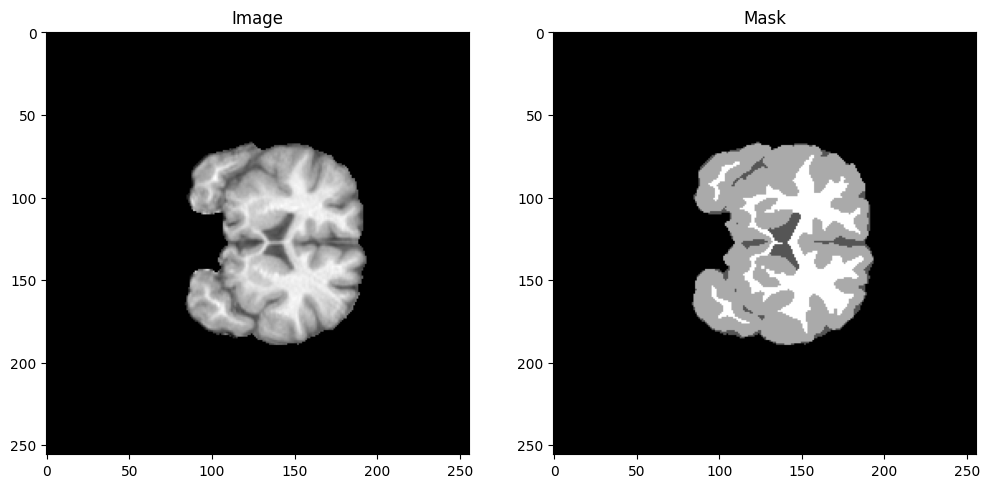

In [ ]:
# Find info of a single image
#print(os.listdir("infant_mri_dataset/train/img")) #is to print current directory
#print(os.listdir("/content/drive/My Drive/Colab Notebooks/adult_mri_dataset/"))

ni2 = '/content/drive/My Drive/Colab Notebooks/adult_mri_dataset_shahad/train/img/img_001.nii.gz'
n2_img= nib.load(ni2)
n2_header = n2_img.header
#print(type(n2_img))
#print(n2_header)
data = n2_img.get_fdata()
print(type(data))

ni1 = '/content/drive/My Drive/Colab Notebooks/adult_mri_dataset_shahad/train/mask/mask_001.nii.gz'
n2_seg= nib.load(ni1)
n2_header = n2_seg.header
data2 = n2_seg.get_fdata()
#data2 = convert_label(data2)

print(data.shape)

#data = data.reshape(256,128,256)
data = data[:,:,:,0]
data = torch.from_numpy(data)
data = torch.permute(data,[0,2,1])
data = data.numpy()
print(data.shape)

data2 = data2[:,:,:,0]
data2 = torch.from_numpy(data2)
data2 = torch.permute(data2,[0,2,1])
data2 = data2.numpy()
plt.figure(figsize=(12, 8), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(data[:,:,80],cmap = 'gray')
plt.title('Image')


plt.subplot(1, 2, 2)
plt.imshow(data2[:,:,80],cmap = 'gray')
plt.title('Mask')


In [ ]:
# the codes are apated from paper T.D. Bui, J. Shin and T. Moon / Biomedical Signal Processing and Control 54 (2019) 101613
# h5py is a dataset
import h5py
#Path to your dataset (img, hdr files)
data_path = '/content/drive/My Drive/Colab Notebooks/adult_mri_dataset_shahad/train'
#Saved path
target_path = './adult_data_train_nocut'
#Reference https://github.com/zhengyang-wang/Unet_3D/tree/master/preprocessing
def cut_edge(data, keep_margin):
    '''
    function that cuts zero edge
    '''
    D, H, W = data.shape
    D_s, D_e = 0, D - 1
    H_s, H_e = 0, H - 1
    W_s, W_e = 0, W - 1

    while D_s < D:
        if data[D_s].sum() != 0:
            break
        D_s += 1
    while D_e > D_s:
        if data[D_e].sum() != 0:
            break
        D_e -= 1
    while H_s < H:
        if data[:, H_s].sum() != 0:
            break
        H_s += 1
    while H_e > H_s:
        if data[:, H_e].sum() != 0:
            break
        H_e -= 1
    while W_s < W:
        if data[:, :, W_s].sum() != 0:
            break
        W_s += 1
    while W_e > W_s:
        if data[:, :, W_e].sum() != 0:
            break
        W_e -= 1

    if keep_margin != 0:
        D_s = max(0, D_s - keep_margin)
        D_e = min(D - 1, D_e + keep_margin)
        H_s = max(0, H_s - keep_margin)
        H_e = min(H - 1, H_e + keep_margin)
        W_s = max(0, W_s - keep_margin)
        W_e = min(W - 1, W_e + keep_margin)

    return int(D_s), int(D_e), int(H_s), int(H_e), int(W_s), int(W_e)

# This function rewrite the masks to correct values
def convert_label2(mask):
        modified_mask = np.zeros_like(mask)
        modified_mask[mask == 1] = 1
        modified_mask[mask == 2] = 2
        modified_mask[mask == 3] = 3
        return modified_mask

def build_h5_dataset(data_path, target_path):
    '''
    Build HDF5 Image Dataset.
    '''
    print(os.listdir(data_path+"/img"))
    for i in range(0,12):
        if i <= 8:

                 subject_name = 'img/img_00%d' % (i + 1)
                 f_T1 = os.path.join(data_path, subject_name + '.nii.gz')
                 img_T1 = nib.load(f_T1).get_fdata()
                 subject_name2 = 'mask/mask_00%d' % (i + 1)
                 f_l = os.path.join(data_path, subject_name2 + '.nii.gz')
                 labels = nib.load(f_l).get_fdata()
        if i>8:
                subject_name = 'img/img_0%d' % (i + 1)
                f_T1 = os.path.join(data_path, subject_name + '.nii.gz')
                img_T1 = nib.load(f_T1).get_fdata()
                subject_name2 = 'mask/mask_0%d' % (i + 1)
                f_l = os.path.join(data_path, subject_name2 + '.nii.gz')
                labels = nib.load(f_l).get_fdata()

        img_T1 = img_T1[:,:,:,0]
        img_T1 = torch.from_numpy(img_T1)
        img_T1 = torch.permute(img_T1,[0,2,1])
        img_T1 = img_T1.numpy()
        inputs_T1 = img_T1.astype(np.float32)

        labels = labels[:,:,:,0]
        labels = torch.from_numpy(labels)
        labels = torch.permute(labels,[0,2,1])
        labels = labels.numpy()
        labels = labels.astype(np.uint8)
        labels=convert_label2(labels)


        # Normalization
        mask=inputs_T1>0
        inputs_T1_norm = (inputs_T1 - inputs_T1[mask].mean()) / inputs_T1[mask].std()


        # Cut edge
        margin = 64/2   # training_patch_size / 2
        mask = mask.astype(np.uint8)
        min_D_s, max_D_e, min_H_s, max_H_e, min_W_s, max_W_e = cut_edge(mask, margin)
        inputs_tmp_T1 = inputs_T1_norm[min_D_s:max_D_e + 1, min_H_s: max_H_e + 1, min_W_s:max_W_e + 1]


        labels_tmp = labels[min_D_s:max_D_e + 1, min_H_s: max_H_e + 1, min_W_s:max_W_e + 1]

        inputs_tmp_T1 = inputs_tmp_T1

        labels_tmp= labels_tmp
        inputs_tmp_T1 = inputs_tmp_T1[:, :, :,None]

        labels_tmp = labels_tmp[:, :, :,None]

        inputs = np.concatenate((inputs_tmp_T1,inputs_tmp_T1),axis = 3)
        inputs_caffe = inputs[None, :, :, :, :]
        labels_caffe = labels_tmp[None, :, :, :, :]

        inputs_caffe = inputs_caffe.transpose(0,4, 3, 1, 2)
        labels_caffe = labels_caffe.transpose(0,4, 3, 1, 2)
        print (inputs_caffe.shape, labels_caffe.shape)
        # The below function re-write the cutted images to hf format for better data loading
        with h5py.File(os.path.join(target_path, 'train_iseg_nocut_%s.h5' % (i+1)), 'w') as f:
            f['data'] = inputs_caffe  # for caffe num channel x d x h x w
            f['label'] = labels_caffe

if __name__ == '__main__':
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    build_h5_dataset(data_path, target_path)

In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/adult_mri_dataset_shahad/valid'
#Saved path
target_path = './adult_data_valid_nocut'
def build_h5_dataset(data_path, target_path):
    '''
    Build HDF5 Image Dataset.
    '''
    print(os.listdir(data_path+"/img"))
    for i in range(0,3):
        if i <= 8:

                 subject_name = 'img/img_00%d' % (i + 1)
                 f_T1 = os.path.join(data_path, subject_name + '.nii.gz')
                 img_T1 = nib.load(f_T1).get_fdata()
                 subject_name2 = 'mask/mask_00%d' % (i + 1)
                 f_l = os.path.join(data_path, subject_name2 + '.nii.gz')
                 labels = nib.load(f_l).get_fdata()


        img_T1 = img_T1[:,:,:,0]
        img_T1 = torch.from_numpy(img_T1)
        img_T1 = torch.permute(img_T1,[0,2,1])
        img_T1 = img_T1.numpy()
        inputs_T1 = img_T1.astype(np.float32)

        labels = labels[:,:,:,0]
        labels = torch.from_numpy(labels)
        labels = torch.permute(labels,[0,2,1])
        labels = labels.numpy()
        labels = labels.astype(np.uint8)
        labels=convert_label2(labels)


        # Normalization
        mask=inputs_T1>0
        inputs_T1_norm = (inputs_T1 - inputs_T1[mask].mean()) / inputs_T1[mask].std()


        # Cut edge
        margin = 64/2   # training_patch_size / 2
        mask = mask.astype(np.uint8)
        min_D_s, max_D_e, min_H_s, max_H_e, min_W_s, max_W_e = cut_edge(mask, margin)
        inputs_tmp_T1 = inputs_T1_norm[min_D_s:max_D_e + 1, min_H_s: max_H_e + 1, min_W_s:max_W_e + 1]


        labels_tmp = labels[min_D_s:max_D_e + 1, min_H_s: max_H_e + 1, min_W_s:max_W_e + 1]

        inputs_tmp_T1 = inputs_tmp_T1

        labels_tmp= labels_tmp
        inputs_tmp_T1 = inputs_tmp_T1[:, :, :,None]

        labels_tmp = labels_tmp[:, :, :,None]

        inputs = np.concatenate((inputs_tmp_T1,inputs_tmp_T1),axis = 3)
        inputs_caffe = inputs[None, :, :, :, :]
        labels_caffe = labels_tmp[None, :, :, :, :]

        inputs_caffe = inputs_caffe.transpose(0,4, 3, 1, 2)
        labels_caffe = labels_caffe.transpose(0,4, 3, 1, 2)
        print (inputs_caffe.shape, labels_caffe.shape)
        # The below function re-write the cutted images to hf format for better data loading
        with h5py.File(os.path.join(target_path, 'valid_iseg_nocut_%s.h5' % (i+1)), 'w') as f:
            f['data'] = inputs_caffe  # for caffe num channel x d x h x w
            f['label'] = labels_caffe

if __name__ == '__main__':
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    build_h5_dataset(data_path, target_path)

<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
(1, 2, 128, 209, 203)
(1, 1, 128, 209, 203)


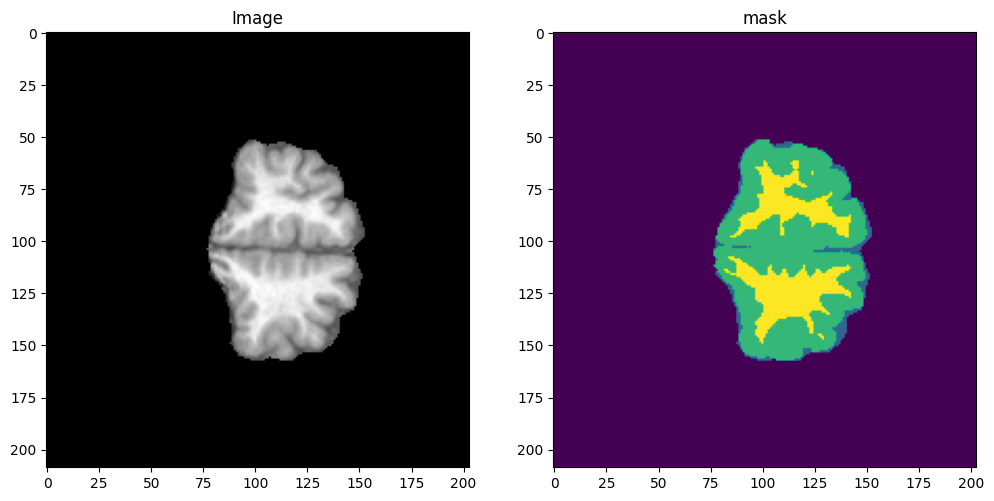

In [ ]:
# display the cutted images and labels to check
f = h5py.File('adult_data_train_nocut/train_iseg_nocut_1.h5','r')
data = f.get('data')
label = f.get('label')
print(type(data))
print(type(label))
print(data.shape)
print(label.shape)

plt.figure(figsize=(12, 8), dpi=100)
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(data[0,0,100,:,:],cmap='gray')
plt.subplot(1, 2, 2)
plt.title('mask')
plt.imshow(label[0,0,100,:,:])
f.close()

In [ ]:
# Construct data loader
import h5py
import torch
import torch.utils.data as data
import glob
import os
from common import *

#BCHW order
class H5Dataset(data.Dataset):

    def __init__(self, root_path, crop_size=crop_size, mode='train'):
        self.hdf5_list = [x for x in glob.glob(os.path.join(root_path, '*.h5'))]
        self.crop_size = crop_size
        self.mode = mode
        if (self.mode == 'train'):
            self.hdf5_list =self.hdf5_list + self.hdf5_list + self.hdf5_list + self.hdf5_list


    def __getitem__(self, index):
        h5_file = h5py.File(self.hdf5_list[index])
        self.data = h5_file.get('data')
        self.label = h5_file.get('label')
        self.label=self.label[:,0,...]
        _, _, C, H, W = self.data.shape
        if (self.mode=='train'):
            cx = random.randint(0, C - self.crop_size[0])
            cy = random.randint(0, H - self.crop_size[1])
            cz = random.randint(0, W - self.crop_size[2])

        elif (self.mode == 'val'):
            # -------Center crop----------
            cx = (C - self.crop_size[0])//2
            cy = (H - self.crop_size[1])//2
            cz = (W - self.crop_size[2])//2

        self.data_crop  = self.data [:, :, cx: cx + self.crop_size[0], cy: cy + self.crop_size[1], cz: cz + self.crop_size[2]]
        self.label_crop = self.label[:,  cx: cx + self.crop_size[0], cy: cy + self.crop_size[1], cz: cz + self.crop_size[2]]
        #print(self.data_crop.shape, self.label_crop.shape)
        # ------End random crop-------------
        #h5_file.close()
        return (torch.from_numpy(self.data_crop[0,:,:,:,:]).float(),
                torch.from_numpy(self.label_crop[0,:,:,:]).long())

    def __len__(self):
        return len(self.hdf5_list)

In [ ]:
#the codes are apated from paper
#T.D. Bui, J. Shin and T. Moon / Biomedical Signal Processing and Control 54 (2019) 101613
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv3d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv3d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv3d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))

        self.add_module('pool_norm', nn.BatchNorm3d(num_output_features))
        self.add_module('pool_relu', nn.ReLU(inplace=True))
        self.add_module('pool', nn.Conv3d(num_output_features, num_output_features, kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self, growth_rate=16, block_config=(6, 12, 24, 16),
                 num_init_features=32, bn_size=4, drop_rate=0, num_classes=9):

        super(DenseNet, self).__init__()

        # First three convolutions
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv3d(2, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
            ('norm0', nn.BatchNorm3d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('conv1', nn.Conv3d(num_init_features, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
            ('norm1', nn.BatchNorm3d(num_init_features)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv3d(num_init_features, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
        ]))
        self.features_bn = nn.Sequential(OrderedDict([
            ('norm2', nn.BatchNorm3d(num_init_features)),
            ('relu2', nn.ReLU(inplace=True)),
        ]))
        self.conv_pool_first = nn.Conv3d(num_init_features, num_init_features, kernel_size=2, stride=2, padding=0,
                                         bias=False)

        # Each denseblock
        num_features = num_init_features
        self.dense_blocks = nn.ModuleList([])
        self.transit_blocks = nn.ModuleList([])
        self.upsampling_blocks = nn.ModuleList([])

        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)

            self.dense_blocks.append(block)

            num_features = num_features + num_layers * growth_rate

            up_block = nn.ConvTranspose3d(num_features, num_classes, kernel_size=2 ** (i + 1) + 2,
                                          stride=2 ** (i + 1),
                                          padding=1, groups=num_classes, bias=False)

            self.upsampling_blocks.append(up_block)

            if i != len(block_config) - 1:


                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.transit_blocks.append(trans)
                #self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        #self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        # Linear layer
        #self.classifier = nn.Linear(num_features, num_classes)
        #self.bn4 = nn.BatchNorm3d(num_features)


        # ----------------------- classifier -----------------------
        self.bn_class = nn.BatchNorm3d(num_classes * 4  +num_init_features)
        self.conv_class = nn.Conv3d(num_classes * 4+num_init_features , num_classes, kernel_size=1, padding=0)
        # ----------------------------------------------------------


        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal(m.weight)
                #nn.Conv3d.bias.data.fill_(-0.1)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)

    def forward(self, x):
        first_three_features = self.features(x)
        first_three_features_bn = self.features_bn(first_three_features)
        out = self.conv_pool_first(first_three_features_bn)

        out = self.dense_blocks[0](out)
        up_block1 = self.upsampling_blocks[0](out)
        out = self.transit_blocks[0](out)

        out = self.dense_blocks[1](out)
        up_block2 = self.upsampling_blocks[1](out)
        out = self.transit_blocks[1](out)

        out = self.dense_blocks[2](out)
        up_block3 = self.upsampling_blocks[2](out)
        out = self.transit_blocks[2](out)

        out = self.dense_blocks[3](out)
        up_block4 = self.upsampling_blocks[3](out)
        #
        out =  torch.cat([up_block1, up_block2, up_block3, up_block4, first_three_features], 1)

        # ----------------------- classifier -----------------------
        out = self.conv_class(F.relu(self.bn_class(out)))
        # ----------------------------------------------------------

        return out

In [ ]:
# Define dice scores for 3 classes
def dice(im1, im2,tid):
    im1=im1==tid
    im2=im2==tid
    im1=np.asarray(im1).astype(np.bool)
    im2=np.asarray(im2).astype(np.bool)
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    dsc=2. * intersection.sum() / (im1.sum() + im2.sum())
    return dsc

In [ ]:
!mkdir checkpoints

In [ ]:
import torch.utils.data as dataloader
import torch.optim as optim
from common import *

# --------------------------CUDA check-----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# -------------init Seg---------------
model_S = DenseNet(num_init_features=32, growth_rate=16, block_config=(4, 4, 4, 4), drop_rate=0.2, num_classes=num_classes).to(device)
# --------------Loss---------------------------
criterion_S = nn.CrossEntropyLoss().cuda()
# setup optimizer
lr_S = 0.0002
optimizer_S = optim.Adam(model_S.parameters(), lr=lr_S, weight_decay=6e-4, betas=(0.97, 0.999))
scheduler_S = optim.lr_scheduler.StepLR(optimizer_S, step_size=step_size_S, gamma=0.1)
num_epoch = 700
train_loss = list()
train_dice = list()
valid_dice = list()
valid_loss = list()
# --------------Start Training and Validation ---------------------------
if __name__ == '__main__':
    #-----------------------Training--------------------------------------
    mri_data_train = H5Dataset("./adult_data_train_nocut", mode='train')
    trainloader = dataloader.DataLoader(mri_data_train, batch_size=batch_train, shuffle=True)
    mri_data_val = H5Dataset("./adult_data_valid_nocut", mode='val')
    valloader = dataloader.DataLoader(mri_data_val, batch_size=1, shuffle=False)
    print('Rate     | epoch  | Loss seg| DSC_val')
    for epoch in range (num_epoch):
        scheduler_S.step(epoch)
        # zero the parameter gradients
        model_S.train()
        for i, data in enumerate(trainloader):
            images, targets = data
            # Set mode cuda if it is enable, otherwise mode CPU
            images = images.to(device)
            targets = targets.to(device)
            optimizer_S.zero_grad()
            outputs = model_S(images)
            loss_seg = criterion_S(outputs, targets) #Crossentropy loss for Seg
            loss_seg.backward()
            optimizer_S.step()
            x = loss_seg.data.cpu().numpy()
            train_loss.append(x)
             # ----------Compute dice-----------
            _, predictedt = torch.max(outputs.data, 1)
            predicted_train = predictedt.data.cpu().numpy()
            targets_train = targets.data.cpu().numpy()
            dsc_t = []
            for i in range(1, num_classes):  # ignore Background 0
                dsc_t_i = dice(predicted_train, targets_train, i)
                dsc_t.append(dsc_t_i)
            dsc_t = np.mean(dsc_t)
            train_dice.append(dsc_t)

        # -----------------------Validation------------------------------------
        # no update parameter gradients during validation

        dsc = None
        with torch.no_grad():
            for data_val in valloader:
                images_val, targets_val = data_val
                model_S.eval()
                images_val = images_val.to(device)
                targets_val = targets_val.to(device)

                outputs_val = model_S(images_val)
                loss_seg_val = criterion_S(outputs_val, targets_val)
                y = loss_seg_val.data.cpu().numpy()
                valid_loss.append(y)


                _, predicted = torch.max(outputs_val.data, 1)
                # ----------Compute dice-----------
                dsc_list = []
                predicted_val = predicted.data.cpu().numpy()
                targets_val = targets_val.data.cpu().numpy()
                for i in range(1, num_classes):  # ignore Background 0
                    dsc_i = dice(predicted_val, targets_val, i)
                    dsc_list.append(dsc_i)
                dsc = np.mean(dsc_list)
                valid_dice.append(dsc)

        #-------------------Debug-------------------------
        for param_group in optimizer_S.param_groups:
            print('%0.6f | %6d | %0.5f | %0.5f ' % (\
                    param_group['lr'], epoch,
                    # loss_seg,
                    loss_seg.data.cpu().numpy(),
                    #dsc for center path
                    dsc))

      #Save checkpoint
        if epoch >= (num_epoch - 500):
            torch.save(model_S.state_dict(), 'checkpoints/' + '%s_%s.pth' % (str(epoch).zfill(5), checkpoint_name))

In [ ]:
# calculate the average loss and dice score over batches in each epoch
train_loss_m = []
train_dice_m = []
batch_train = 4
for i in range (0, num_epoch):
        mean = sum(train_loss[i*4:i*4+batch_train])/batch_train
        train_loss_m.append(mean)
for i in range (0, num_epoch):
        mean2 = sum(train_dice[i*4:i*4+batch_train])/batch_train
        train_dice_m.append(mean2)

In [ ]:
# calculate the average loss and dice score over batches in each epoch
valid_loss_m = []
valid_dice_m = []
valid_imagen = 3
for i in range (0, num_epoch):
        mean = sum(valid_loss[i*3:i*3+valid_imagen])/valid_imagen
        valid_loss_m.append(mean)
for i in range (0, num_epoch):
        mean2 = sum(valid_dice[i*3:i*3+valid_imagen])/valid_imagen
        valid_dice_m.append(mean2)

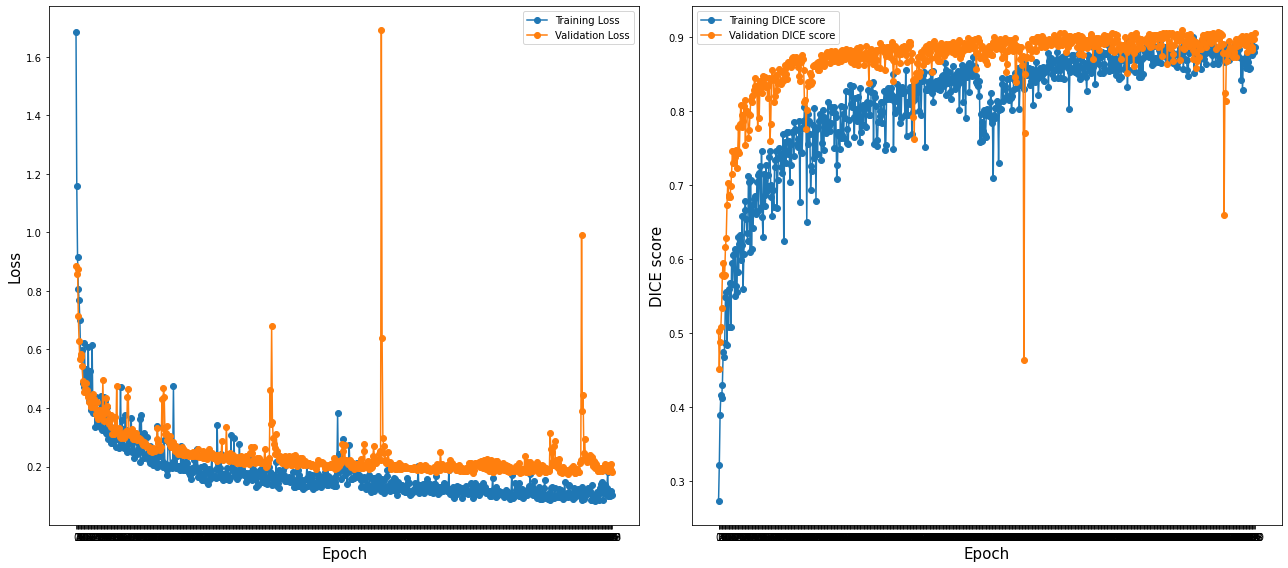

In [ ]:
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(np.arange(num_epoch),  train_loss_m, '-o', label='Training Loss')
plt.plot(np.arange(num_epoch),  valid_loss_m, '-o', label='Validation Loss')
plt.xticks(np.arange(num_epoch))
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(num_epoch), train_dice_m, '-o', label='Training DICE score')
plt.plot(np.arange(num_epoch), valid_dice_m, '-o', label='Validation DICE score')
plt.xticks(np.arange(num_epoch))
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
best_epoch = np.argmax(valid_dice_m)

print(f'Best epoch is epoch{best_epoch}')
# load parameters from saved checkpoints
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_S = DenseNet(num_init_features=32, growth_rate=16, block_config=(4, 4, 4, 4), drop_rate=0.2, num_classes=num_classes).to(device)
#best_epoch = 450
s = 'checkpoints/00{}_model_3d_denseseg_v1.pth'.format(best_epoch)
saved_state_dict = torch.load(s)
model_S.load_state_dict(saved_state_dict)
model_S.eval()

In [ ]:
from metrics import dice
import time


#############################
# Read Nii/hdr file
#############################
data_path = '/content/drive/My Drive/Colab Notebooks/adult_mri_dataset_shahad/test'
test_path = '/content/drive/My Drive/Colab Notebooks/adult_mri_dataset_shahad/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = model_S

xstep = 8
ystep = 8
zstep = 8
whole_pred_all = np.zeros([3,4,128,256,256])

for ii in range(0,3):
    subject_name = 'img/img_00%d' % (ii + 1)
    f_T1 = os.path.join(data_path, subject_name + '.nii.gz')
    img_T1 = nib.load(f_T1).get_fdata()
    subject_name2 = 'mask/mask_00%d' % (ii + 1)
    f_l = os.path.join(data_path, subject_name2 + '.nii.gz')
    labels = nib.load(f_l).get_fdata()


    img_T1 = img_T1[:,:,:,0]
    img_T1 = torch.from_numpy(img_T1)
    img_T1 = torch.permute(img_T1,[0,2,1])
    img_T1 = img_T1.numpy()
    inputs_T1 = img_T1.astype(np.float32)

    labels = labels[:,:,:,0]
    labels = torch.from_numpy(labels)
    labels = torch.permute(labels,[0,2,1])
    labels = labels.numpy()
    labels = labels.astype(np.uint8)
    labels=convert_label2(labels)



    inputs_T1 = img_T1.astype(np.float32)


    labels = labels.astype(np.uint8)
    labels=convert_label2(labels)

 # Normalization
    mask=inputs_T1>0
    inputs_T1_norm = (inputs_T1 - inputs_T1[mask].mean()) / inputs_T1[mask].std()


    inputs_T1_norm = inputs_T1_norm[:, :, :,None]

    inputs = np.concatenate((inputs_T1_norm,inputs_T1_norm),axis = 3)
    image = inputs[None, :, :, :, :]


    image = image.transpose(0,4, 3, 1, 2)

    _, _, C, H, W = image.shape
    deep_slices   = np.arange(0, C - crop_size[0] + xstep, xstep)
    height_slices = np.arange(0, H - crop_size[1] + ystep, ystep)
    width_slices  = np.arange(0, W - crop_size[2] + zstep, zstep)
    whole_pred = np.zeros((1,)+(num_classes,) + image.shape[2:])
    count_used = np.zeros((image.shape[2], image.shape[3], image.shape[4])) + 1e-5



    # no update parameter gradients during testing
    with torch.no_grad():
        for i in range(len(deep_slices)):
            for j in range(len(height_slices)):
                for k in range(len(width_slices)):
                            deep = deep_slices[i]
                            height = height_slices[j]
                            width = width_slices[k]
                            image_crop = image[:, :, deep   : deep   + crop_size[0],
                                                        height : height + crop_size[1],
                                                        width  : width  + crop_size[2]]
                            image_crop = torch.from_numpy(image_crop)
                            image_crop = image_crop.to(device='cuda')
                            outputs = net(image_crop)
                            #----------------Average-------------------------------
                            whole_pred[slice(None), slice(None), deep: deep + crop_size[0],
                                        height: height + crop_size[1],
                                        width: width + crop_size[2]] += outputs.data.cpu().numpy()

                            count_used[deep: deep + crop_size[0],
                                        height: height + crop_size[1],
                                        width: width + crop_size[2]] += 1

                        #----------------Major voting-------------------------------
                        # _, temp_predict = torch.max(outputs.data, 1)
                        # for labelInd in range(num_classes):  # note, start from 0
                        #     currLabelMat = np.where(temp_predict == labelInd, 1, 0)  # true, vote for 1, otherwise 0
                        #     whole_pred[slice(None), labelInd, deep: deep + crop_size[0],
                        #     height: height + crop_size[1],
                        #     width: width + crop_size[2]] += currLabelMat

                        # count_used[deep: deep + crop_size[0],
                        #             height: height + crop_size[1],
                        #             width: width + crop_size[2]] += 1
        whole_pred = whole_pred / count_used
        whole_pred_all[ii,:,:,:,:] = whole_pred
        #whole_pred = whole_pred / count_used
        #whole_pred = whole_pred[0, :, :, :, :]
        #whole_pred = np.argmax(whole_pred, axis=0)
        #Write to file
        #f_pred = os.path.join(test_path, subject_name + 'label.hdr')
        #whole_pred = whole_pred.transpose(2,1,0)
        #whole_pred = convert_label(whole_pred)

In [ ]:
print(whole_pred_all.shape)

(3, 4, 128, 256, 256)


In [ ]:
# Output the final prediction result
#whole_pred2 = whole_pred / count_used
whole_pred_all2 = np.zeros([3,256,256,128])
for i in range (0,3):
  whole_pred2 = whole_pred_all[i, :, :, :, :]
  whole_pred2 = np.argmax(whole_pred2, axis=0)
  whole_pred2 = whole_pred2.transpose(1,2,0)
  whole_pred2 = whole_pred2[0:290,0:290,0:203]
  whole_pred2 = convert_label2(whole_pred2)
  whole_pred_all2[i,:,:,:,] = whole_pred2
  m = np.max(whole_pred2)
  print(m)

3
3
3


In [ ]:
 # Calculate test dice score
dsc_test_all = np.zeros([3,3])

for ii in range (0,3):
  subject_name2 = 'mask/mask_00%d' % (ii + 1)
  f_l = os.path.join(data_path, subject_name2 + '.nii.gz')
  labels = nib.load(f_l).get_fdata()
  labels = labels[:,:,:,0]
  labels = torch.from_numpy(labels)
  labels = torch.permute(labels,[0,2,1])
  labels = labels.numpy()
  labels = labels.astype(np.uint8)
  labels=convert_label2(labels)

  dsc_test = np.zeros(3)
  for i in range(1, num_classes):  # ignore Background 0
                      dsc_i = dice(whole_pred_all2[ii,:,:,:], labels, i)
                      dsc_test[i-1] = dsc_i
                      dsc_test_mean = np.mean(dsc_test)
                      dsc_test_all[ii,:] = dsc_test

dsc_test_class = np.average(dsc_test_all,axis = 0)
dsc_mean_all = np.mean(dsc_test_class)
print(dsc_test_class)
print(dsc_mean_all)

[0.77263063 0.93504781 0.90870495]
0.8721277971669078


In [ ]:
    plt.figure(figsize=(12,8))
    plt.title('Performance')
    plt.bar(0, dsc_test_class[0], label='CSF', color = '#00688B')
    plt.bar(1, dsc_test_class[1], label='Gray Matter',color = '#32CD32')
    plt.bar(2, dsc_test_class[2], label='White Matter',color = '#FFD700')
    plt.ylabel('DICE Score')
    plt.xticks([0,1,2],['CSF', 'Gray Matter', 'White matter'])
    plt.legend()
    plt.show()

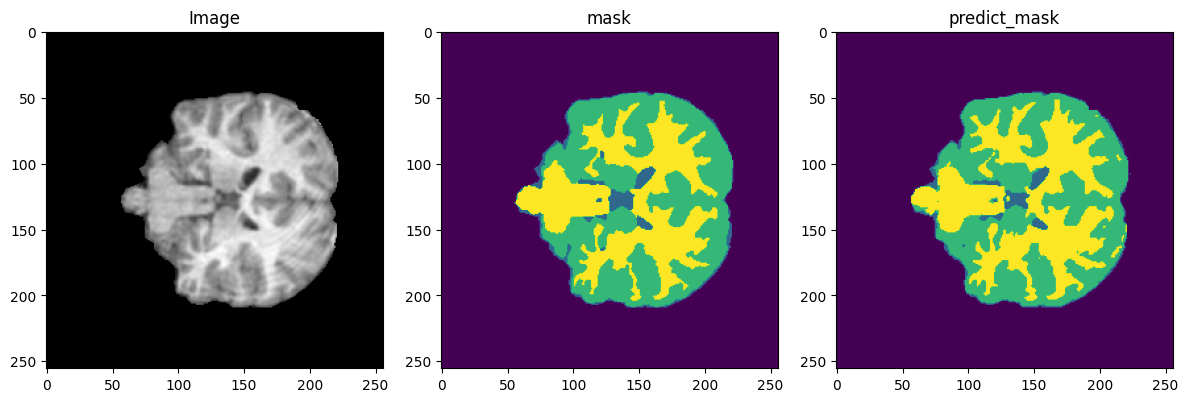

In [ ]:
plt.figure(figsize=(12, 8), dpi=100)
plt.subplot(1, 3, 1)
plt.title('Image')
plt.imshow(img_T1[:,:,50],cmap = 'gray')


plt.subplot(1, 3, 2)
plt.title('mask')
plt.imshow(labels[:,:,50])

plt.subplot(1, 3, 3)
plt.title('predict_mask')
plt.imshow(whole_pred2[:,:,50])


plt.tight_layout()
plt.show()

In [ ]:
# the codes are apated from paper T.D. Bui, J. Shin and T. Moon / Biomedical Signal Processing and Control 54 (2019) 101613
# h5py is a dataset
import h5py
#Path to your dataset (img, hdr files)
data_path = '/content/drive/My Drive/Colab Notebooks/infant_mri_dataset/train'
#Saved path
target_path = './infant_data_train_nocut'
#Reference https://github.com/zhengyang-wang/Unet_3D/tree/master/preprocessing
def cut_edge(data, keep_margin):
    '''
    function that cuts zero edge
    '''
    D, H, W = data.shape
    D_s, D_e = 0, D - 1
    H_s, H_e = 0, H - 1
    W_s, W_e = 0, W - 1

    while D_s < D:
        if data[D_s].sum() != 0:
            break
        D_s += 1
    while D_e > D_s:
        if data[D_e].sum() != 0:
            break
        D_e -= 1
    while H_s < H:
        if data[:, H_s].sum() != 0:
            break
        H_s += 1
    while H_e > H_s:
        if data[:, H_e].sum() != 0:
            break
        H_e -= 1
    while W_s < W:
        if data[:, :, W_s].sum() != 0:
            break
        W_s += 1
    while W_e > W_s:
        if data[:, :, W_e].sum() != 0:
            break
        W_e -= 1

    if keep_margin != 0:
        D_s = max(0, D_s - keep_margin)
        D_e = min(D - 1, D_e + keep_margin)
        H_s = max(0, H_s - keep_margin)
        H_e = min(H - 1, H_e + keep_margin)
        W_s = max(0, W_s - keep_margin)
        W_e = min(W - 1, W_e + keep_margin)

    return int(D_s), int(D_e), int(H_s), int(H_e), int(W_s), int(W_e)

# This function rewrite the masks to correct values
def convert_label(mask):
        modified_mask = np.zeros_like(mask)
        modified_mask[mask == 1] = 1
        modified_mask[mask == 2] = 2
        modified_mask[mask == 7] = 2
        modified_mask[mask == 3] = 3
        return modified_mask

def build_h5_dataset(data_path, target_path):
    '''
    Build HDF5 Image Dataset.
    '''
    for i in range(0,4):

        subject_name = 'img/img_00%d' % (i + 1)
        f_T1 = os.path.join(data_path, subject_name + '.nii.gz')
        img_T1 = nib.load(f_T1).get_fdata()
        subject_name2 = 'mask/seg_00%d' % (i + 1)
        f_l = os.path.join(data_path, subject_name2 + '.nii.gz')
        labels = nib.load(f_l).get_fdata()

        inputs_T1 = img_T1.astype(np.float32)

        labels = labels.astype(np.uint8)
        labels=convert_label(labels)


        # Normalization
        mask=inputs_T1>0
        inputs_T1_norm = (inputs_T1 - inputs_T1[mask].mean()) / inputs_T1[mask].std()


        # Cut edge
        margin = 64/2   # training_patch_size / 2
        mask = mask.astype(np.uint8)
        min_D_s, max_D_e, min_H_s, max_H_e, min_W_s, max_W_e = cut_edge(mask, margin)
        inputs_tmp_T1 = inputs_T1_norm[min_D_s:max_D_e + 1, min_H_s: max_H_e + 1, min_W_s:max_W_e + 1]


        labels_tmp = labels[min_D_s:max_D_e + 1, min_H_s: max_H_e + 1, min_W_s:max_W_e + 1]

        inputs_tmp_T1 = inputs_tmp_T1

        labels_tmp= labels_tmp
        inputs_tmp_T1 = inputs_tmp_T1[:, :, :,None]

        labels_tmp = labels_tmp[:, :, :,None]

        inputs = np.concatenate((inputs_tmp_T1,inputs_tmp_T1),axis = 3)
        inputs_caffe = inputs[None, :, :, :, :]
        labels_caffe = labels_tmp[None, :, :, :, :]

        inputs_caffe = inputs_caffe.transpose(0,4, 3, 1, 2)
        labels_caffe = labels_caffe.transpose(0,4, 3, 1, 2)
        print (inputs_caffe.shape, labels_caffe.shape)
        # The below function re-write the cutted images to hf format for better data loading
        with h5py.File(os.path.join(target_path, 'train_iseg_nocut_%s.h5' % (i+1)), 'w') as f:
            f['data'] = inputs_caffe  # for caffe num channel x d x h x w
            f['label'] = labels_caffe

if __name__ == '__main__':
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    build_h5_dataset(data_path, target_path)

(1, 2, 203, 275, 290) (1, 1, 203, 275, 290)
(1, 2, 203, 283, 290) (1, 1, 203, 283, 290)
(1, 2, 203, 275, 290) (1, 1, 203, 275, 290)
(1, 2, 203, 266, 290) (1, 1, 203, 266, 290)


In [ ]:
# Do the same precedure for valid dataset
data_path = '/content/drive/My Drive/Colab Notebooks/infant_mri_dataset/valid'
target_path = './infant_data_val_nocut'

def build_h5_dataset(data_path, target_path):
    '''
    Build HDF5 Image Dataset.
    '''

    subject_name = 'img/img_005'
    f_T1 = os.path.join(data_path, subject_name + '.nii.gz')
    img_T1 = nib.load(f_T1).get_fdata()
    subject_name2 = 'mask/seg_005'
    f_l = os.path.join(data_path, subject_name2 + '.nii.gz')
    labels = nib.load(f_l).get_fdata()

    inputs_T1 = img_T1.astype(np.float32)

    labels = labels.astype(np.uint8)
    labels=convert_label(labels)


        # Normalization
    mask=inputs_T1>0
    inputs_T1_norm = (inputs_T1 - inputs_T1[mask].mean()) / inputs_T1[mask].std()


        # Cut edge
    margin = 64/2   # training_patch_size / 2
    mask = mask.astype(np.uint8)
    min_D_s, max_D_e, min_H_s, max_H_e, min_W_s, max_W_e = cut_edge(mask, margin)
    inputs_tmp_T1 = inputs_T1_norm[min_D_s:max_D_e + 1, min_H_s: max_H_e + 1, min_W_s:max_W_e + 1]


    labels_tmp = labels[min_D_s:max_D_e + 1, min_H_s: max_H_e + 1, min_W_s:max_W_e + 1]

    inputs_tmp_T1 = inputs_tmp_T1

    labels_tmp= labels_tmp
    inputs_tmp_T1 = inputs_tmp_T1[:, :, :,None]

    labels_tmp = labels_tmp[:, :, :,None]

    inputs = np.concatenate((inputs_tmp_T1,inputs_tmp_T1),axis = 3)
    inputs_caffe = inputs[None, :, :, :, :]
    labels_caffe = labels_tmp[None, :, :, :, :]

    inputs_caffe = inputs_caffe.transpose(0,4, 3, 1, 2)
    labels_caffe = labels_caffe.transpose(0,4, 3, 1, 2)
    print (inputs_caffe.shape, labels_caffe.shape)
    i = 0
    with h5py.File(os.path.join(target_path, 'val_iseg_nocut_%s.h5' % (i+1)), 'w') as f:
        f['data'] = inputs_caffe  # for caffe num channel x d x h x w
        f['label'] = labels_caffe

if __name__ == '__main__':
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    build_h5_dataset(data_path, target_path)

(1, 2, 203, 270, 290) (1, 1, 203, 270, 290)


In [ ]:

model_S2 = model_S
#for param in model_S2.parameters():
   #param.requires_grad = False

#model_S2 = nn.Sequential(*list(model_S.children())[:-1],
                          #nn.Conv3d(48 , 4, kernel_size=1, padding=0)
                          #).to(device)
#model_S2.eval()


In [ ]:
x = torch.randn(1, 2, 3, 224, 224).cuda()
model_S2(x).shape

In [ ]:
!mkdir infant_checkpoints

In [ ]:
import torch.utils.data as dataloader
import torch.optim as optim
from common import *

# --------------------------CUDA check-----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------Loss---------------------------
criterion_S = nn.CrossEntropyLoss().cuda()
# setup optimizer
lr_S = 0.0002
optimizer_S = optim.Adam(model_S2.parameters(), lr=lr_S, weight_decay=6e-4, betas=(0.97, 0.999))
scheduler_S = optim.lr_scheduler.StepLR(optimizer_S, step_size=step_size_S, gamma=0.1)
num_epoch = 2000
train_loss = list()
train_dice = list()
valid_dice = list()
valid_loss = list()
# --------------Start Training and Validation ---------------------------
if __name__ == '__main__':
    #-----------------------Training--------------------------------------
    mri_data_train = H5Dataset("./infant_data_train_nocut", mode='train')
    trainloader = dataloader.DataLoader(mri_data_train, batch_size=batch_train, shuffle=True)
    mri_data_val = H5Dataset("./infant_data_val_nocut", mode='val')
    valloader = dataloader.DataLoader(mri_data_val, batch_size=1, shuffle=False)
    print('Rate     | epoch  | Loss seg| DSC_val')
    for epoch in range (num_epoch):
        scheduler_S.step(epoch)
        # zero the parameter gradients
        model_S2.train()
        for i, data in enumerate(trainloader):
            images, targets = data
            # Set mode cuda if it is enable, otherwise mode CPU
            images = images.to(device)
            targets = targets.to(device)
            optimizer_S.zero_grad()
            outputs = model_S2(images)
            loss_seg = criterion_S(outputs, targets) #Crossentropy loss for Seg
            loss_seg.backward()
            optimizer_S.step()
            x = loss_seg.data.cpu().numpy()
            train_loss.append(x)
             # ----------Compute dice-----------
            _, predictedt = torch.max(outputs.data, 1)
            predicted_train = predictedt.data.cpu().numpy()
            targets_train = targets.data.cpu().numpy()
            dsc_t = []
            for i in range(1, num_classes):  # ignore Background 0
                dsc_t_i = dice(predicted_train, targets_train, i)
                dsc_t.append(dsc_t_i)
            dsc_t = np.mean(dsc_t)
            train_dice.append(dsc_t)

        # -----------------------Validation------------------------------------
        # no update parameter gradients during validation
        with torch.no_grad():
            for data_val in valloader:
                images_val, targets_val = data_val
                model_S.eval()
                images_val = images_val.to(device)
                targets_val = targets_val.to(device)

                outputs_val = model_S2(images_val)
                loss_seg_val = criterion_S(outputs_val, targets_val)
                y = loss_seg_val.data.cpu().numpy()
                valid_loss.append(y)


                _, predicted = torch.max(outputs_val.data, 1)
                # ----------Compute dice-----------
                predicted_val = predicted.data.cpu().numpy()
                targets_val = targets_val.data.cpu().numpy()
                dsc = []
                for i in range(1, num_classes):  # ignore Background 0
                    dsc_i = dice(predicted_val, targets_val, i)
                    dsc.append(dsc_i)
                dsc = np.mean(dsc)
                valid_dice.append(dsc)

                # outputs_val = model_S(images_val)
                # _, predicted = torch.max(outputs_val.data, 1)
                # # ----------Compute dice-----------
                # predicted = predicted.squeeze()
                # targets_val = targets_val.data[0].cpu().numpy()
                # dsc = []
                # for i in range(1, num_classes):  # ignore Background 0
                #     if (np.sum(targets_val[targets_val==i])>0):
                #         dsc_i = dice(predicted, targets_val, i)
                #         dsc.append(dsc_i)
                # dsc = np.mean(dsc)

        #-------------------Debug-------------------------
        for param_group in optimizer_S.param_groups:
            print('%0.6f | %6d | %0.5f | %0.5f ' % (\
                    param_group['lr'], epoch,
                    # loss_seg,
                    loss_seg.data.cpu().numpy(),
                    #dsc for center path
                    dsc))

      #Save checkpoint
        if epoch >= (num_epoch - 500):
            torch.save(model_S.state_dict(), 'infant_checkpoints/' + '%s_%s.pth' % (str(epoch).zfill(5), checkpoint_name))